# Lecture 11, Methods for multiobjective optimization 

If you want to know more about the topic of this lecture, I urge you to read Professor Miettinen's book Nonlinear Multiobjective Optimization

![Nonlinear Multiobjective Optimization](images/Miettinen2.gif)

## Classification of methods

Methods for multiobjective optimization are often characterized by the involvement of the decision maker in the process.

The types of methods are
* **no preference methods**, where the decision maker does not play a role,
* **a priori methods**, where the decision maker gives his/her preference information at first and then the optimization method finds the best match to that preference information,
* **a posteriori methods**, where the optimization methods try to characterize all/find a good representation of the Pareto optimal solutions and the decision maker chooses the most preferred one of those,
* **interactive methods**, where the optimization method and the decision maker alternate in iterative search for the most preferred solution.

## Multiple Criteria Decision Making (MCDM)
* The related research field is called multiple criteria decision making
* More information in the website of the <a href="http://www.mcdmsociety.org/">International Society on MCDM</a>

##  Our example problem for this lecture

We study a hypothetical decision problem of buying a car, when you can choose to have a car with power between (denoted by $p$) 50 and 200 kW and average consumption (denoted by $c$) per 100 km between 3 and 10 l. However, in addition to the average consumption and power, you need to decide the volume of the cylinders (v), which may be between 1000 $cm^3$ and 4000 $cm^3$. Finally, the price of the car follows now a function 
$$
\left(\sqrt{\frac{p-50}{50}}\\
+\left(\frac{p-50}{50}\right)^2+0.3(10-c)\\ +10^{-5}\left(v-\left(1000+3000\frac{p-50}{150}\right)\right)^2\right)10000\\+5000
$$
in euros. This problem can be formulated as a multiobjective optimization problem
$$
\begin{align}
\min \quad & \{c,-p,P\},\\
\text{s.t. }\quad
&50\leq p\leq 200\\
&3\leq c\leq 10\\
&1000\leq v\leq 4000,\\
\text{where }\quad&P = \left(\sqrt{\frac{p-50}{50}}+\left(\frac{p-50}{50}\right)^2+0.3(10-c)\right.\\
& \left.+ 10^{-5}\left(v-\left(1000+3000\frac{p-50}{150}\right)\right)^2\right)10000+5000
\end{align}
$$

In [25]:
#Let us define a Python function which returns the value of this
import math
def car_problem(c,p,v):
#    import pdb; pdb.set_trace()
    return [#Objective function values
        c,-p,
        (math.sqrt((p-50.)/50.)+((p-50.)/50.)**2+
        0.3*(10.-c)+0.00001*(v-(1000.+3000.*(p-50.)/150.))**2)*10000.
        +5000.] 

In [26]:
print("Car with 3 l/100km consumption, 50kW and 1000cm^3 engine would cost "
      +str(car_problem(3,50,1000)[2])+"€")
print("Car with 3 l/100km consumption, 100kW and 2000cm^3 engine would cost "
      +str(car_problem(3,100,2000)[2])+"€")
print("Car with 3 l/100km consumption, 100kW and 1000cm^3 engine would cost "
      +str(car_problem(3,100,1000)[2])+"€")

Car with 3 l/100km consumption, 50kW and 1000cm^3 engine would cost 26000.0€
Car with 3 l/100km consumption, 100kW and 2000cm^3 engine would cost 46000.0€
Car with 3 l/100km consumption, 100kW and 1000cm^3 engine would cost 146000.0€


## Normalization of the objectives

**In many of the methods, the normalization of the objectives is necessary.**

We can normalize the objectives using the nadir and ideal and setting the normalized objective as
$$ \tilde f_i = \frac{f_i-z_i^{ideal}}{z_i^{nadir}-z_i^{ideal}}$$

## Calculating the ideal

**Finding the ideal for problems is usually easy, if you can optimize the objective functions separately.**

For the car problem, ideal can be computed easily using the script:

In [27]:
#Calculating the ideal
from scipy.optimize import minimize
import ad
def calc_ideal(f):
    ideal = [0]*3 #Because three objectives
    solutions = [] #list for storing the actual solutions, which give the ideal
    bounds = ((3,10),(50,200),(1000,4000)) #Bounds of the problem
    for i in range(3):
        res=minimize(
            #Minimize each objective at the time
            lambda x: f(x[0],x[1],x[2])[i], [3,50,1000], method='SLSQP'
            #Jacobian using automatic differentiation
            ,jac=ad.gh(lambda x: f(x[0],x[1],x[2])[i])[0]
            #bounds given above
            ,bounds = bounds
            ,options = {'disp':True, 'ftol': 1e-20, 'maxiter': 1000})
        solutions.append(f(res.x[0],res.x[1],res.x[2]))
        ideal[i]=res.fun
    return ideal,solutions

In [28]:
ideal, solutions= calc_ideal(car_problem)
print ("ideal is "+str(ideal))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.0
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -200.0
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5000.0
            Iterations: 4
            Function evaluations: 3
            Gradient evaluations: 3
ideal is [3.0, -200.0, 5000.0]


## Pay-off table method

**Finding the nadir value is however, usually much harder.**

Usually, the nadir value is estimated using the so-called pay-off table method.

The pay-off table method does not guarantee to find the exact nadir for problems with more than two objectives. <!--(One of your exercises this week will be to show this.)--> 

The method is, however, a generally accepted way of approximating the nadir vector.

In the pay-off table method:
1. the objective values for attaining the individual minima are added in table
2. the nadir is estimated by each objectives maxima in the table.
3. the ideal values are located in the diagonal of the pay-off table

### The nadir for the car selection problem
The table now becomes by using the *solutions* that we returned while calculating the ideal

In [29]:
for solution in solutions:
    print(solution)

[3.0, -50.0, 26000.0]
[3.0, -200.0, 1033320.5080756888]
[10.0, -50.0, 5000.0]


Thus, the esimation of the nadir vector is 
$$(10,-50,1033320.5080756888)$$

This is actually the real Nadir vector for this problem.

### Normalized car problem

In [30]:
#Let us define a Python function which returns the value of this
import math
def car_problem_normalized(c,p,v):
    z_ideal = [3.0, -200.0, 5000]
    z_nadir = [10,-50,1033320.5080756888]
    z = car_problem(c,p,v) 
    return [(zi-zideali)/(znadiri-zideali) for 
            (zi,zideali,znadiri) in zip(z,z_ideal,z_nadir)]

<a href="https://docs.python.org/3.3/library/functions.html#zip">the zip function</a> in Python

In [31]:
print("Normalized value of the car problem at (3,50,1000) is "
      +str(car_problem_normalized(3,50,1000)))
print("Normalized value of the car problem at (3,125,2500) is "
      +str(car_problem_normalized(3,125,2500)))
print("Normalized value of the car problem at (10,100,1000) is "
      +str(car_problem_normalized(10,100,1000)))

Normalized value of the car problem at (3,50,1000) is [0.0, 1.0, 0.020421648537670038]
Normalized value of the car problem at (3,125,2500) is [0.0, 0.5, 0.054212133547970276]
Normalized value of the car problem at (10,100,1000) is [1.0, 0.6666666666666666, 0.11669513450097163]


**So, value 1 now indicates the worst value on the Pareto frontier and value 0 indicates the best values**

Let's set the ideal and nadir for later reference:

In [32]:
z_ideal = [3.0, -200.0, 5000]
z_nadir = [10.,-50,1033320.5080756888]

**From now on, we will deal with the normalized problem, although, we write just $f$.** The aim of this is to simplify presentation.

## No preference methods

* Usually only for situations, where the decision maker is not available or does not want to get involved
* These just compute a single Pareto optimal solution, which is in somehow mathematically thought as the best compromise

## Notation

For short, let us denote the feasible set $\{x\in\mathbb R^n: g_j(x) \geq 0 \text{ for all }j=1,\ldots,J \text{ and } h_k(x) = 0\text{ for all }k=1,\ldots,K\}$ by $S$.

### Method of Global criterion

Involved minimization of the p-norm of $f(x)-z^{ideal}$, that is we solve the problem
$$
\min_{x\in S} \|f(x) - z^{ideal}\|_p.
$$

![alt text](images/mgc.svg "Method of global criterion")

**An optimal solution to this problem is Pareto optimal**

### Applying to our problem studied


In [33]:
import numpy as np
def global_criterion_method(f,p):
    #Ideal for any normalized problem is (0,0,0)
    ideal = [0,0,0]
    bounds = ((3,10),(50,200),(1000,4000)) #Bounds of the problem
    #Objective is the norm of objective function values minus
    #the ideal
    obj = lambda x: np.linalg.norm(np.array(f(x[0],x[1],x[2]))
                                   -np.array(ideal),ord=p)
    res=minimize(
            #Minimize p distance from the ideal
            obj, [3,50,1000], method='SLSQP'
            #Jacobian using automatic differentiation
            ,jac=ad.gh(obj)[0]
            #bounds given above
            ,bounds = bounds,options = {'disp':True})
    return res.x

In [34]:
solution = global_criterion_method(car_problem_normalized,
                                           2)
print("variable values are ",solution)
f_global_criterion = car_problem(solution[0],solution[1],solution[2])
print("objective values are ",f_global_criterion)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5511608009378004
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
variable values are  [   3.05218231  138.07878375 1000.00730072]
objective values are  [3.0521823078769694, -138.07878374832924, 380459.6917582024]


In [35]:
help (np.linalg.norm)

Help on function norm in module numpy.linalg.linalg:

norm(x, ord=None, axis=None, keepdims=False)
    Matrix or vector norm.
    
    This function is able to return one of eight different matrix norms,
    or one of an infinite number of vector norms (described below), depending
    on the value of the ``ord`` parameter.
    
    Parameters
    ----------
    x : array_like
        Input array.  If `axis` is None, `x` must be 1-D or 2-D.
    ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
        Order of the norm (see table under ``Notes``). inf means numpy's
        `inf` object.
    axis : {int, 2-tuple of ints, None}, optional
        If `axis` is an integer, it specifies the axis of `x` along which to
        compute the vector norms.  If `axis` is a 2-tuple, it specifies the
        axes that hold 2-D matrices, and the matrix norms of these matrices
        are computed.  If `axis` is None then either a vector norm (when `x`
        is 1-D) or a matrix norm (when `x` is

In [36]:
solution = global_criterion_method(car_problem_normalized,
                                           np.inf)
print("variable values are ",solution) 
f_global_criterion = car_problem(solution[0],solution[1],solution[2])
print("objective values are ",f_global_criterion)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.39082299975504164
            Iterations: 16
            Function evaluations: 28
            Gradient evaluations: 16
variable values are  [   3.00553518  141.37702887 1000.00067459]
objective values are  [3.005535175678426, -141.37702887399757, 406891.3056757692]


C:\Devel\Anaconda3\lib\site-packages\ad\__init__.py:827: RuntimeWarning: invalid value encountered in double_scalars
  lc_wrt_args = [x/abs(x)]


## A posteriori methods

* A posteriori methods generate a representation of the Pareto optimal solutions, or the complete set of Pareto optimal solutions
* Benefits
  * The solutions can be visualized for problems with 2 or 3 objectives so the decision making is possible
  * When succesful, they give an understanding of the Pareto front
* Drawbacks
  * Approximating the Pareto optimal set often time-consuming
  * Decision making from a large representation may be very difficut


### The weighting method

Based on solving optimization problem
$$
\min_{x\in S} \sum_{i=1}^kw_if_i(x)
$$
for different weights $w_i\geq0$, $i=1,\ldots,k$ such that $\sum_{i=1}^k w_i=1$. 

**The idea is to generate weights evenly and then have evenly spread solutions.**

**An optimal solution of the weighted problem is Pareto optimal, if all the weights $w_i$ are $>0$.**

![alt text](images/ws.svg "Weighting method")

### Application to our problem

In [37]:
import numpy as np
def weighting_method(f,w):
    points = []
    bounds = ((3,10),(50,200),(1000,4000)) #Bounds of the problem
    for wi in w:
        res=minimize(
            #weighted sum
            lambda x: sum(np.array(wi)*np.array(f(x[0],x[1],x[2]))), 
            [3,50,1000], method='SLSQP'
            #Jacobian using automatic differentiation
            ,jac=ad.gh(lambda x: sum(np.array(wi)*np.array(f(x[0],x[1],x[2]))))[0]
            #bounds given above
            ,bounds = bounds,options = {'disp':False})
        points.append(res.x)
    return points

In [38]:
w = np.random.random((500,3)) #500 random weights
repr = weighting_method(car_problem_normalized,w)

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def visualize_representation(func,repr):
    f_repr = [func(repri[0],repri[1],repri[2]) for repri in repr]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([f[0] for f in f_repr],[f[1] for f in f_repr],[f[2] for f in f_repr])
    return plt

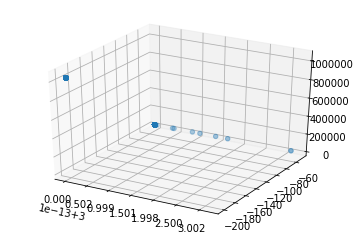

In [40]:
visualize_representation(car_problem,repr).show()